# Bot Detector (XLM-R)

This notebook trains a **bot detector** using **XLM-RoBERTa** on the same data as the feature-based notebook:
- **Posts & users**: `dataset.posts&users.*.json`
- **Bot labels**: `dataset.bots.*.txt`

Each user is represented by the **concatenated text** of their posts; the model learns to distinguish bot vs human from language and content.

---

**Design rationale.** We use XLM-R for multilingual robustness and rich linguistic representation. User-level aggregation (concatenation with [SEP]) trades off per-post granularity for a single vector per user—appropriate when labels are at the author level. Progressive fine-tuning (head → top layers → full) mitigates catastrophic forgetting on small datasets.

## 1. Install dependencies

In [32]:
pip install transformers datasets torch scikit-learn emoji accelerate>=1.1.0


zsh:1: 1.1.0 not found
Note: you may need to restart the kernel to use updated packages.


## 2. Preprocessing (critical for XLM-R)

- **Do not lowercase**: Capitalization is a feature (e.g. "FREE MONEY" vs "Free money"); XLM-R is case-sensitive.
- **Keep emojis**: Demojize to text (e.g. 😂 → :joy:) so the tokenizer treats them as words; emojis are affective signals.
- **Mask entities**: Replace URLs with `<URL>` and @mentions with `<USER>` so the model learns structure, not memorized sites.

*Entity masking reduces overfitting to spurious correlations (e.g. specific domains) and improves generalization to unseen users/URLs.*

In [33]:
import json
import re
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emoji
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

DATA_DIR = Path(".")

def preprocess_text(text: str) -> str:
    """Do NOT lowercase. Demojize emojis to text. Mask URLs and @mentions."""
    if not text or not isinstance(text, str):
        return ""
    t = text.strip()
    t = emoji.demojize(t, delimiters=(":", ":"))
    t = re.sub(r"https?://\S+", "<URL>", t)
    t = re.sub(r"@[A-Za-z0-9_]+", "<USER>", t)
    return t

# Verify URL and @mention masking so the model cannot overfit to domains or usernames.
_u = preprocess_text("Check https://t.co/abc123 and http://evil.com/path")
assert _u == "Check <URL> and <URL>", f"URL masking failed: {_u!r}"
_m = preprocess_text("Hi @someuser and @Another_User99!")
assert _m == "Hi <USER> and <USER>!", f"@mention masking failed: {_m!r}"
assert "http" not in preprocess_text("visit https://bot-site.com") and "<URL>" in preprocess_text("visit https://bot-site.com")

def load_bot_ids(dataset_id: int) -> set:
    path = DATA_DIR / f"dataset.bots.{dataset_id}.txt"
    if not path.exists():
        return set()
    with open(path) as f:
        return set(line.strip() for line in f if line.strip())

def load_posts_and_users(dataset_id: int) -> dict:
    path = DATA_DIR / f"dataset.posts&users.{dataset_id}.json"
    with open(path) as f:
        return json.load(f)

def build_user_text_df(dataset_id: int) -> pd.DataFrame:
    """One row per user: author_id, text (all posts concatenated, preprocessed), is_bot."""
    bot_ids = load_bot_ids(dataset_id)
    data = load_posts_and_users(dataset_id)
    posts = data["posts"]
    by_author = defaultdict(list)
    for p in posts:
        raw = p.get("text", "") or ""
        by_author[p["author_id"]].append(preprocess_text(raw))
    rows = []
    for author_id, texts in by_author.items():
        text = " [SEP] ".join(t for t in texts if t)
        if not text:
            text = ""
        rows.append({
            "author_id": author_id,
            "text": text,
            "is_bot": 1 if author_id in bot_ids else 0,
        })
    return pd.DataFrame(rows)

dfs = [build_user_text_df(did) for did in (30, 31, 32, 33)]
combined_df = pd.concat(dfs, ignore_index=True)

# Split by user_id (author_id) so no user in train appears in validation/test.
# One row per user, but we split on unique user IDs explicitly to guarantee no leakage.
user_ids = combined_df[["author_id", "is_bot"]].drop_duplicates()
train_users, test_users = train_test_split(
    user_ids,
    test_size=0.2,
    random_state=42,
    stratify=user_ids["is_bot"],
)
train_user_ids = set(train_users["author_id"])
test_user_ids = set(test_users["author_id"])
assert train_user_ids.isdisjoint(test_user_ids), "Train and test must have disjoint user IDs."

train_df = combined_df[combined_df["author_id"].isin(train_user_ids)].reset_index(drop=True)
test_df = combined_df[combined_df["author_id"].isin(test_user_ids)].reset_index(drop=True)

# Sanity check: zero training user IDs in validation/test set
overlap = train_user_ids & test_user_ids
assert len(overlap) == 0, f"Found {len(overlap)} user IDs in both train and test."

print(f"Combined: {len(combined_df)} users  ({combined_df['is_bot'].sum()} bots)")
print(f"Train:    {len(train_df)} users  ({train_df['is_bot'].sum()} bots)")
print(f"Test:     {len(test_df)} users  ({test_df['is_bot'].sum()} bots)")
print(f"Train/test user ID overlap: {len(train_user_ids & test_user_ids)} (must be 0)")
print(f"Sample text length (train): {train_df['text'].str.len().describe()}")

Combined: 889 users  (184 bots)
Train:    711 users  (147 bots)
Test:     178 users  (37 bots)
Train/test user ID overlap: 0 (must be 0)
Sample text length (train): count      711.000000
mean      3319.123769
std       3181.129703
min         13.000000
25%       1262.500000
50%       2194.000000
75%       4370.500000
max      22572.000000
Name: text, dtype: float64


## 3. Tokenize with XLMRobertaTokenizer (do not use a generic BERT tokenizer)

*XLM-R uses SentencePiece with a 250k subword vocab; mismatch with base BERT tokenizer would corrupt embeddings. max_length=512 respects typical input limits while truncating long concatenations.*

In [34]:
from datasets import Dataset
from transformers import XLMRobertaTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

MODEL_NAME = "xlm-roberta-base"
MAX_LENGTH = 512

# Use XLMRobertaTokenizer; do not use a generic BERT tokenizer.
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

# Text is already preprocessed (no lowercasing; emojis demojized; URLs/mentions masked).
def tokenize(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
        return_tensors=None,
    )

train_ds = Dataset.from_pandas(train_df[["text", "is_bot"]].rename(columns={"is_bot": "labels"}))
test_ds = Dataset.from_pandas(test_df[["text", "is_bot"]].rename(columns={"is_bot": "labels"}))

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["text"])
train_ds.set_format("torch")

test_ds = test_ds.map(tokenize, batched=True, remove_columns=["text"])
test_ds.set_format("torch")

print("Train dataset:", train_ds)
print("Test dataset:", test_ds)

Map: 100%|██████████| 178/178 [00:00<00:00, 1417.27 examples/s]

Train dataset: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 711
})
Test dataset: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 178
})


In [35]:
import os
import torch

# Prefer Metal (MPS) on Apple Silicon for GPU acceleration; fallback to CUDA then CPU.
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # Run unsupported ops on CPU instead of erroring

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Metal (MPS) for compute.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA for compute.")
else:
    device = torch.device("cpu")
    print("Using CPU for compute. (Set PYTORCH_ENABLE_MPS_FALLBACK=1 on Mac if you expected Metal.)")

# If you hit OOM on Metal, force CPU: device = torch.device("cpu")

Using Metal (MPS) for compute.


## 5-Fold Stratified Cross Validation

Evaluates XLM-R with the same 3-phase progressive fine-tuning across 5 stratified folds on the **full dataset** (all 889 users). Each fold reinitializes the model from pretrained weights and runs head-only, top-2-layers, then full fine-tuning. Reports per-fold and aggregate metrics (mean +/- std).

**Note:** This takes ~30 minutes (5 folds x 3 phases x 3 epochs each).

*Progressive unfreezing acts as discriminative LR scheduling—preserves lower layers while adapting task-specific representations. Stratified folds maintain class balance for reliable variance estimates.*

In [36]:
# === 5-Fold Stratified Cross Validation (XLM-R) ===
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader

K = 5

# --- Helper: Weighted Trainer (CrossEntropyLoss with class weights) ---
class WeightedTrainerCV(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            shuffle=True,
            collate_fn=self.data_collator,
            drop_last=getattr(self.args, "dataloader_drop_last", False),
            num_workers=getattr(self.args, "dataloader_num_workers", 0),
            pin_memory=getattr(self.args, "dataloader_pin_memory", True),
        )

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# --- Freezing helpers ---
def cv_freeze_base(mdl):
    """Freeze all XLM-R encoder layers; only train the classification head."""
    for name, param in mdl.named_parameters():
        param.requires_grad = "classifier" in name

def cv_unfreeze_top_n(mdl, n=2):
    """Unfreeze the top n transformer layers + classification head."""
    for name, param in mdl.named_parameters():
        if "classifier" in name:
            param.requires_grad = True
        elif "roberta.encoder.layer" in name:
            layer_idx = int(name.split("encoder.layer.")[1].split(".")[0])
            param.requires_grad = layer_idx >= 12 - n
        else:
            param.requires_grad = False

def cv_unfreeze_all(mdl):
    """Unfreeze entire model for full fine-tuning."""
    for param in mdl.parameters():
        param.requires_grad = True

def cv_compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    f1_val = f1_score(labels, preds, average="binary", pos_label=1)
    return {"accuracy": acc, "f1": f1_val}

# --- Run K-Fold ---
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
cv_user_ids = combined_df[["author_id", "is_bot"]].drop_duplicates()

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(cv_user_ids, cv_user_ids["is_bot"]), 1):
    print(f"\n{'=' * 65}")
    print(f"  Fold {fold}/{K}")
    print(f"{'=' * 65}")

    fold_train_ids = set(cv_user_ids.iloc[train_idx]["author_id"])
    fold_val_ids = set(cv_user_ids.iloc[val_idx]["author_id"])

    fold_train_df = combined_df[combined_df["author_id"].isin(fold_train_ids)].reset_index(drop=True)
    fold_val_df = combined_df[combined_df["author_id"].isin(fold_val_ids)].reset_index(drop=True)

    # Tokenize
    fold_train_ds = Dataset.from_pandas(fold_train_df[["text", "is_bot"]].rename(columns={"is_bot": "labels"}))
    fold_val_ds = Dataset.from_pandas(fold_val_df[["text", "is_bot"]].rename(columns={"is_bot": "labels"}))
    fold_train_ds = fold_train_ds.map(tokenize, batched=True, remove_columns=["text"])
    fold_train_ds.set_format("torch")
    fold_val_ds = fold_val_ds.map(tokenize, batched=True, remove_columns=["text"])
    fold_val_ds.set_format("torch")

    # Class weights for this fold
    n_total_fold = len(fold_train_df)
    n_bot_fold = int(fold_train_df["is_bot"].sum())
    n_human_fold = n_total_fold - n_bot_fold
    cw = torch.tensor(
        [n_total_fold / (2 * n_human_fold), n_total_fold / (2 * n_bot_fold)],
        dtype=torch.float32, device=device,
    )

    # Fresh model from pretrained weights
    fold_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    fold_model = fold_model.to(device)
    fold_model.gradient_checkpointing_enable()

    # 3-phase progressive fine-tuning
    phases = [
        ("head only", cv_freeze_base, 3),
        ("top 2 layers", lambda m: cv_unfreeze_top_n(m, 2), 3),
        ("full fine-tune", cv_unfreeze_all, 3),
    ]

    fold_trainer = None
    for phase_num, (phase_name, freeze_fn, epochs) in enumerate(phases, 1):
        freeze_fn(fold_model)

        phase_args = TrainingArguments(
            output_dir=f"./xlmr_cv/fold{fold}_phase{phase_num}",
            num_train_epochs=epochs,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=8,
            gradient_accumulation_steps=4,
            weight_decay=0.01,
            max_grad_norm=1.0,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1",
            greater_is_better=True,
            save_total_limit=2,
            logging_steps=50,
            report_to="none",
        )

        fold_trainer = WeightedTrainerCV(
            model=fold_model,
            args=phase_args,
            train_dataset=fold_train_ds,
            eval_dataset=fold_val_ds,
            compute_metrics=cv_compute_metrics,
            class_weights=cw,
        )
        fold_trainer.train()
        print(f"  Phase {phase_num} ({phase_name}) complete.")

    # Evaluate on this fold's validation set
    predictions = fold_trainer.predict(fold_val_ds)
    y_pred = np.argmax(predictions.predictions, axis=-1)
    y_true = fold_val_df["is_bot"].values

    acc = accuracy_score(y_true, y_pred)
    f1_val = f1_score(y_true, y_pred, average="binary", pos_label=1)
    prec = precision_score(y_true, y_pred, average="binary", pos_label=1)
    rec = recall_score(y_true, y_pred, average="binary", pos_label=1)

    fold_results.append({"fold": fold, "accuracy": acc, "f1": f1_val, "precision": prec, "recall": rec})
    print(f"\n  Fold {fold} result: Acc={acc:.4f}  F1={f1_val:.4f}  Prec={prec:.4f}  Recall={rec:.4f}")

    # Cleanup to free GPU memory between folds
    del fold_model, fold_trainer, fold_train_ds, fold_val_ds
    gc.collect()
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()

# Summary
cv_results_df = pd.DataFrame(fold_results)
print("\n" + "=" * 65)
print("  XLM-R 5-Fold Stratified Cross Validation Summary")
print("=" * 65)
for metric in ["accuracy", "f1", "precision", "recall"]:
    mean_val = cv_results_df[metric].mean()
    std_val = cv_results_df[metric].std()
    print(f"  {metric.capitalize():>10s}:  {mean_val:.4f} +/- {std_val:.4f}")
print("=" * 65)


  Fold 1/5


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1396.44it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Con

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.675773,0.792135,0.000000
2,2.672721,0.672333,0.792135,0.000000
3,2.578015,0.673705,0.792135,0.000000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 1 (head only) complete.


/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.438747,0.926966,0.811594
2,2.345873,0.301077,0.932584,0.812500
3,1.508244,0.253080,0.898876,0.780488


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 2 (top 2 layers) complete.


/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.300430,0.882022,0.778947
2,1.357971,0.149514,0.955056,0.894737
3,0.716120,0.188604,0.943820,0.880952


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 3 (full fine-tune) complete.



  Fold 1 result: Acc=0.9551  F1=0.8947  Prec=0.8718  Recall=0.9189

  Fold 2/5


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1549.84it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Con

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.674917,0.792135,0.000000
2,2.689369,0.671327,0.792135,0.000000
3,2.602539,0.676131,0.792135,0.000000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 1 (head only) complete.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.431127,0.825843,0.617284
2,2.241712,0.285767,0.898876,0.742857
3,1.411390,0.247567,0.910112,0.771429


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 2 (top 2 layers) complete.


/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.182064,0.921348,0.833333
2,1.681951,0.160750,0.966292,0.918919
3,0.635765,0.180937,0.966292,0.921053


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 3 (full fine-tune) complete.



  Fold 2 result: Acc=0.9663  F1=0.9211  Prec=0.8974  Recall=0.9459

  Fold 3/5


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1745.62it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Con

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.679428,0.792135,0.000000
2,2.674940,0.675025,0.792135,0.000000
3,2.602118,0.676828,0.792135,0.000000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 1 (head only) complete.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.401589,0.910112,0.733333
2,2.227518,0.339991,0.926966,0.800000
3,1.615927,0.247390,0.943820,0.864865


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 2 (top 2 layers) complete.


/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.221265,0.955056,0.882353
2,1.451063,0.640542,0.949438,0.861538
3,1.031043,0.062219,0.983146,0.961039


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 3 (full fine-tune) complete.



  Fold 3 result: Acc=0.9831  F1=0.9610  Prec=0.9250  Recall=1.0000

  Fold 4/5


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1791.12it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Con

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.668776,0.792135,0.000000
2,2.650974,0.666032,0.792135,0.000000
3,2.600379,0.665447,0.792135,0.000000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 1 (head only) complete.


/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.359621,0.893258,0.753247
2,2.073455,0.213372,0.932584,0.837838
3,1.457694,0.197144,0.921348,0.820513


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 2 (top 2 layers) complete.


/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.165918,0.926966,0.843373
2,1.820898,0.091279,0.960674,0.911392
3,0.667262,0.074354,0.977528,0.947368


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 3 (full fine-tune) complete.



  Fold 4 result: Acc=0.9775  F1=0.9474  Prec=0.9231  Recall=0.9730

  Fold 5/5


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1526.56it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Con

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.674294,0.796610,0.000000
2,2.652495,0.670852,0.796610,0.000000
3,2.629092,0.669895,0.796610,0.000000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 1 (head only) complete.


/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.476303,0.875706,0.666667
2,2.390330,0.348727,0.887006,0.722222
3,1.454252,0.375308,0.881356,0.740741


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 2 (top 2 layers) complete.


/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.417576,0.898305,0.775000
2,1.561718,0.367641,0.943503,0.848485
3,0.717095,0.263230,0.949153,0.876712


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

  Phase 3 (full fine-tune) complete.



  Fold 5 result: Acc=0.9492  F1=0.8767  Prec=0.8649  Recall=0.8889

  XLM-R 5-Fold Stratified Cross Validation Summary
    Accuracy:  0.9662 +/- 0.0144
          F1:  0.9202 +/- 0.0352
   Precision:  0.8964 +/- 0.0280
      Recall:  0.9453 +/- 0.0437


## 4. Load model and define metrics

In [37]:
import torch

# Class weights for imbalanced bot/human: Weight_class = Total / (2 * Class_count)
n_total = len(train_df)
n_bot = int(train_df["is_bot"].sum())
n_human = n_total - n_bot
weight_human = n_total / (2 * n_human)
weight_bot = n_total / (2 * n_bot)
class_weights = torch.tensor([weight_human, weight_bot], dtype=torch.float32, device=device)
print("Class weights (Human, Bot):", class_weights.tolist())

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)  # Use Metal (MPS), CUDA, or CPU from cell above
model.gradient_checkpointing_enable()  # Reduces GPU memory (trade compute for memory)

# Trainer that uses CrossEntropyLoss with class weights
from torch.utils.data import DataLoader

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            shuffle=True,
            collate_fn=self.data_collator,
            drop_last=getattr(self.args, "dataloader_drop_last", False),
            num_workers=getattr(self.args, "dataloader_num_workers", 0),
            pin_memory=getattr(self.args, "dataloader_pin_memory", True),
        )

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# --- Freezing helpers (reduce catastrophic forgetting, speed up early training) ---
def freeze_base_train_head_only(model):
    """Freeze all XLM-R encoder layers; only train the classification head."""
    for name, param in model.named_parameters():
        if "classifier" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

def unfreeze_top_n_layers(model, n=2):
    """Unfreeze the top n transformer layers + classification head. XLM-R base has 12 layers (0–11)."""
    for name, param in model.named_parameters():
        if "classifier" in name:
            param.requires_grad = True
        elif "roberta.encoder.layer" in name:
            # layer index is e.g. roberta.encoder.layer.11.xxx
            layer_idx = int(name.split("encoder.layer.")[1].split(".")[0])
            if layer_idx >= 12 - n:  # top n layers
                param.requires_grad = True
        else:
            param.requires_grad = False

def unfreeze_all(model):
    """Unfreeze entire model for full fine-tuning; needed to align encoder vector space with the task."""
    for param in model.parameters():
        param.requires_grad = True

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    f1 = f1_score(labels, preds, average="binary", pos_label=1)
    return {"accuracy": acc, "f1": f1}

# Save a checkpoint every epoch; at end of each phase, load the checkpoint with best eval F1 (avoids overfitting).
training_args = TrainingArguments(
    output_dir="./xlmr_bot_detector",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    max_grad_norm=1.0,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=5,
    logging_steps=50,
    report_to="none",
)

# Start with only the classification head trainable (prevents catastrophic forgetting).
freeze_base_train_head_only(model)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)
print("Model and Trainer ready (base frozen, head only; weighted CrossEntropyLoss).")

Class weights (Human, Bot): [0.6303191781044006, 2.418367385864258]


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1709.28it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Con

Model and Trainer ready (base frozen, head only; weighted CrossEntropyLoss).


## 5. Train (staged: head → top 2 layers → full base)

Fine-tuning the base encoder is necessary to align its vector space with the task (not just the head).

- **Phase 1**: 3 epochs with only the classification head (base frozen) — fast, preserves multilingual knowledge.
- **Phase 2**: Unfreeze the **top 2** transformer layers; up to 5 epochs (early stop if eval F1 does not improve for 2 evals).
- **Phase 3**: Unfreeze the **whole model**; up to 5 epochs with early stopping so the full base aligns with the classifier.

/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.280603,0.663609,0.792135,0.000000
2,1.523160,0.667347,0.792135,0.000000
3,1.273853,0.647300,0.792135,0.000000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.918031,0.381536,0.876404,0.725000
2,0.829405,0.355599,0.943820,0.848485
3,0.759303,0.242859,0.915730,0.805195


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.514983,0.225400,0.887640,0.782609
2,0.048297,0.245540,0.904494,0.808989
3,0.002717,0.131316,0.960674,0.911392


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.wei

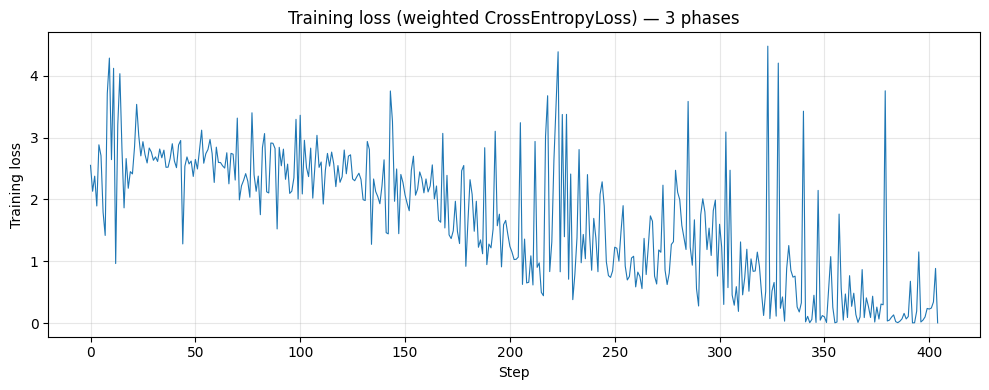

In [38]:
# Collect training loss across all phases for plotting
training_loss_history = []

training_args.logging_steps = 1

# ---- Phase 1: head only (high LR for random head) ----
freeze_base_train_head_only(model)

training_args.learning_rate = 2e-4
training_args.num_train_epochs = 3
training_args.output_dir = "./xlmr_bot_detector/phase1"

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)
trainer.train()
training_loss_history += [e["loss"] for e in trainer.state.log_history if "loss" in e]

# ---- Phase 2: unfreeze top 2 layers ----
unfreeze_top_n_layers(model, n=2)

training_args.learning_rate = 3e-5
training_args.num_train_epochs = 3
training_args.output_dir = "./xlmr_bot_detector/phase2"

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)
trainer.train()
training_loss_history += [e["loss"] for e in trainer.state.log_history if "loss" in e]

# ---- Phase 3: full fine-tuning ----
unfreeze_all(model)

training_args.learning_rate = 2e-5
training_args.num_train_epochs = 3
training_args.output_dir = "./xlmr_bot_detector/phase3"

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)
trainer.train()
training_loss_history += [e["loss"] for e in trainer.state.log_history if "loss" in e]

# ---- Plot training loss across all phases ----
plt.figure(figsize=(10, 4))
plt.plot(training_loss_history, color="tab:blue", linewidth=0.8)

# Mark phase boundaries
phase1_len = len([e for e in trainer.state.log_history if "loss" in e])  # approx
total = len(training_loss_history)
p1_end = total - phase1_len  # rough markers — adjust if you want exact counts

plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss (weighted CrossEntropyLoss) — 3 phases")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Evaluate

/Users/user/Documents/bot detector/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


=== Classification Report ===

              precision    recall  f1-score   support

       Human       0.99      0.96      0.97       141
         Bot       0.86      0.97      0.91        37

    accuracy                           0.96       178
   macro avg       0.92      0.97      0.94       178
weighted avg       0.96      0.96      0.96       178

=== Confusion Matrix ===

[[135   6]
 [  1  36]]


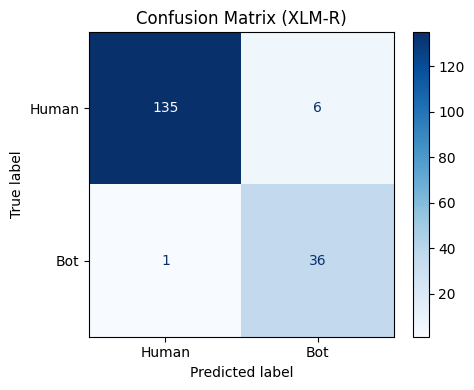


Test F1 (Bot): 0.9114


In [39]:
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_test = test_df["is_bot"].values

print("=== Classification Report ===\n")
print(classification_report(y_test, y_pred, target_names=["Human", "Bot"]))
print("=== Confusion Matrix ===\n")
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay(cm, display_labels=["Human", "Bot"]).plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix (XLM-R)")
plt.tight_layout()
plt.show()
print(f"\nTest F1 (Bot): {f1_score(y_test, y_pred, average='binary', pos_label=1):.4f}")

In [40]:
# === Export OOF XLM-R [CLS] embeddings for BotRGCN ===
# Each fold's best checkpoint extracts [CLS] for its held-out users only,
# so no user's embedding comes from a model fine-tuned on that user.

import os, gc, json as _json
from pathlib import Path
from sklearn.model_selection import StratifiedKFold

os.makedirs("rgcn_features", exist_ok=True)

K_OOF, RANDOM_STATE, BATCH_SIZE, HIDDEN_DIM = 5, 42, 32, 768

export_df = combined_df.drop_duplicates(subset=["author_id"], keep="first").reset_index(drop=True)
cv_user_ids = export_df[["author_id", "is_bot"]].drop_duplicates()
skf_oof = StratifiedKFold(n_splits=K_OOF, shuffle=True, random_state=RANDOM_STATE)

xlmr_oof = np.zeros((len(export_df), HIDDEN_DIM), dtype=np.float32)

for fold, (_, val_idx) in enumerate(skf_oof.split(cv_user_ids, cv_user_ids["is_bot"]), 1):
    fold_val_ids = set(cv_user_ids.iloc[val_idx]["author_id"])
    fold_val_mask = export_df["author_id"].isin(fold_val_ids)
    fold_val_df = export_df[fold_val_mask].reset_index(drop=True)

    # Load best phase-3 checkpoint for this fold (dynamic resolution).
    fold_dir = Path(f"xlmr_cv/fold{fold}_phase3")
    trainer_states = sorted(fold_dir.glob("checkpoint-*/trainer_state.json"))
    best_ckpt = None
    if trainer_states:
        with open(trainer_states[-1]) as f:
            best_ckpt = _json.load(f).get("best_model_checkpoint")
    if not best_ckpt or not Path(best_ckpt).exists():
        ckpt_dirs = sorted(
            [p for p in fold_dir.glob("checkpoint-*") if p.is_dir()],
            key=lambda p: int(p.name.split("-")[-1]),
        )
        if not ckpt_dirs:
            raise FileNotFoundError(f"No checkpoints found for fold {fold} in {fold_dir}")
        best_ckpt = str(ckpt_dirs[-1])
    print(f"Fold {fold}: {best_ckpt}  ({len(fold_val_df)} users)")

    fold_model = AutoModelForSequenceClassification.from_pretrained(best_ckpt, num_labels=2)
    fold_model.to(device).eval()

    fold_ds = Dataset.from_pandas(fold_val_df[["text"]].reset_index(drop=True))
    fold_ds = fold_ds.map(tokenize, batched=True, remove_columns=["text"])
    fold_ds.set_format("torch")

    embs = []
    with torch.no_grad():
        for i in range(0, len(fold_ds), BATCH_SIZE):
            batch = fold_ds[i : i + BATCH_SIZE]
            out = fold_model.roberta(input_ids=batch["input_ids"].to(device),
                                     attention_mask=batch["attention_mask"].to(device))
            embs.append(out.last_hidden_state[:, 0, :].cpu().numpy())

    xlmr_oof[np.where(fold_val_mask.values)[0]] = np.vstack(embs).astype(np.float32)

    del fold_model, embs, fold_ds
    gc.collect()
    if device.type == "mps": torch.mps.empty_cache()

assert (xlmr_oof == 0).all(axis=1).sum() == 0, "Some users missing OOF embeddings"

np.savez_compressed("rgcn_features/xlmr_features.npz",
                    author_ids=export_df["author_id"].values,
                    xlmr_feature_vectors=xlmr_oof)
print(f"\nSaved OOF [CLS] embeddings: {xlmr_oof.shape} → rgcn_features/xlmr_features.npz")

Fold 1: Loading ./xlmr_cv/fold1_phase3/checkpoint-90


Map: 100%|██████████| 178/178 [00:00<00:00, 760.81 examples/s]


  Extracted OOF [CLS] embeddings for 178 users
Fold 2: Loading ./xlmr_cv/fold2_phase3/checkpoint-135


Map: 100%|██████████| 178/178 [00:00<00:00, 1331.86 examples/s]


  Extracted OOF [CLS] embeddings for 178 users
Fold 3: Loading ./xlmr_cv/fold3_phase3/checkpoint-135


Map: 100%|██████████| 178/178 [00:00<00:00, 1128.20 examples/s]


  Extracted OOF [CLS] embeddings for 178 users
Fold 4: Loading ./xlmr_cv/fold4_phase3/checkpoint-135


Map: 100%|██████████| 178/178 [00:00<00:00, 1292.71 examples/s]


  Extracted OOF [CLS] embeddings for 178 users
Fold 5: Loading ./xlmr_cv/fold5_phase3/checkpoint-135


Map: 100%|██████████| 177/177 [00:00<00:00, 1531.01 examples/s]


  Extracted OOF [CLS] embeddings for 177 users

Saved OOF XLM-R [CLS] embeddings: (889, 768)
  (users=889, hidden_dim=768)
  Every user's embeddings come from a model that NEVER saw that user.
  → rgcn_features/xlmr_features.npz
